# Machine Learning Train pipeline

1. Use different data timewindow

2. Show distribution and plots for training set

2. Run it in different machine learning model

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn import tree, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from sklearn.metrics import \
    classification_report, \
    plot_confusion_matrix, \
    confusion_matrix, \
    roc_curve, \
    auc, \
    f1_score, accuracy_score, recall_score

## Define Functions and Consts

In [2]:
timewindows = [1, 3, 5, 10, 15, 20, 30]


In [3]:
def load_data(path) -> pd.DataFrame:
    df = pd.read_csv(path)
    return df

def plot_ROC(y_test, y_pred, plt_config):    
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=plt_config['figsize'])
        plt.title('ROC')
        plt.plot(fpr, tpr, 'b', label='ROC-AUC = %0.2f' % roc_auc)
        plt.plot([0,1], [0,1], 'y--', label='baseline')

        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc='best')
        plt.show()

def decisionTreeTrain(X_train, y_train, max_depth):
    clf = tree.DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    return clf

def randomForestTrain(X_train, y_train, max_depth):
    clf = RandomForestClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    return clf

def SVMTrain(X_train, y_train):
    svmclf = make_pipeline(preprocessing.StandardScaler(), SVC(kernel = 'rbf', gamma='auto'))
    svmclf.fit(X_train, y_train)
    return svmclf

def KNNTrain(X_train, y_train):
    knnclf = KNeighborsClassifier()
    knnclf.fit(X_train, y_train)
    return knnclf

def GMMTrain(X_train, n):
    clf =  GaussianMixture(n_components=n)
    clf.fit(X_train)
    return clf

def scalar_normalize(X_train, X_test):
    min_max_scalar = preprocessing.MinMaxScaler()
    X_train_minmax = min_max_scalar.fit_transform(X_train)
    X_test_minmax = min_max_scalar.transform(X_test)
    X_train_scaled = preprocessing.scale(X_train_minmax)
    X_test_scaled = preprocessing.scale(X_test_minmax)
    X_train_normalized = preprocessing.normalize(X_train_scaled, norm='l2')
    X_test_normalized = preprocessing.normalize(X_test_scaled, norm='l2')
    return X_train_normalized, X_test_normalized


NameError: name 'pd' is not defined

In [4]:
def load_windows_data():
    dfs = []
    for t in tqdm(timewindows, desc="Loading Data"):
        path = "../csv_data/user_1_timewindow"+str(t)+".csv"
        dfs.append(load_data(path))
    return dfs

def preprocess_pipeline(dfs):
    ret = []
    for df in tqdm(dfs, desc="Preprocessing"):
        df = df.fillna(-10000)
        # df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
        df = df.replace((np.inf, -np.inf), 0).reset_index(drop=True)
        ret.append(df)
    return ret

def train_test_split_pipeline(dfs, test_size=0.3):
    ret = []
    for df in tqdm(dfs, desc="Spliting"):
        data_X = df.drop(columns = ['timestamp', 'class'])
        data_y = df['class']
        binary_data_y = data_y.copy()
        binary_data_y[binary_data_y>0] = 1
        X_train, X_test, y_train, y_test = train_test_split(data_X, binary_data_y, test_size=test_size)
        ret.append([X_train, X_test, y_train, y_test])
    return ret

def predict_scores(y_true, y_pred):
    accuracy, recall, f1_s = accuracy_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)
    return accuracy, recall, f1_s

def plot_timewindow_figure(scores, method):
    [accuracy_scores, recall_scores, f1_scores, fprs] = scores
    x = timewindows
    fig = plt.figure(facecolor='white',figsize=(13, 5))
    
    for i in range(len(accuracy_scores)):
        print("{}{}{}{}".format(accuracy_scores[i]*100, recall_scores[i]*100, f1_scores[i]*100, fprs[i]*100))

    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy_scores, color='r', label='Accuracy')
    plt.plot(x, recall_scores, color='g', label='Recall')
    plt.plot(x, f1_scores, color='b', label='F1 Score')
    plt.xlabel('Time Window')
    plt.ylabel('Score')
    plt.title(method)
    plt.legend(loc="best")

    plt.subplot(1, 2 ,2)
    plt.plot(x, fprs, color='r')
    plt.xlabel('Time Window')
    plt.ylabel('False Alarm Rate')
    plt.show()

def prediction_pipeline(data, models):
    clfs = models
    accuracy_scores = []
    recall_scores = []
    f1_scores = []
    fprs = []
    for index, [X_train, X_test, y_train, y_test] in enumerate(tqdm(data, desc="Evaluating")):
        clf = clfs[index]
        y_hat = clf.predict(X_test)
        accuracy, recall, f1_s = predict_scores(y_test, y_hat)
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        f1_scores.append(f1_s)
        # calculate false alarm rate
        fp = len([val for index, val in enumerate(y_test)if (val == 0 and y_hat[index] == 1)])
        tn = len([val for index, val in enumerate(y_test)if (val == 1 and y_hat[index] == 1)])
        fprs.append(fp/(fp+tn))
        
    return accuracy_scores, recall_scores, f1_scores, fprs

def plot_pipeline(scores, method):
    plot_timewindow_figure(scores, method)

def data_preparation_pipeline():
    dfs = load_windows_data()
    dfs = preprocess_pipeline(dfs)
    data = train_test_split_pipeline(dfs, test_size=0.3)
    return data

data = data_preparation_pipeline()

Spliting: 100%|█████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 167.11it/s]


## Basic information about Datasets

Preprocessing: 100%|████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 206.43it/s]
Plotting: 7it [00:00, 61.55it/s]


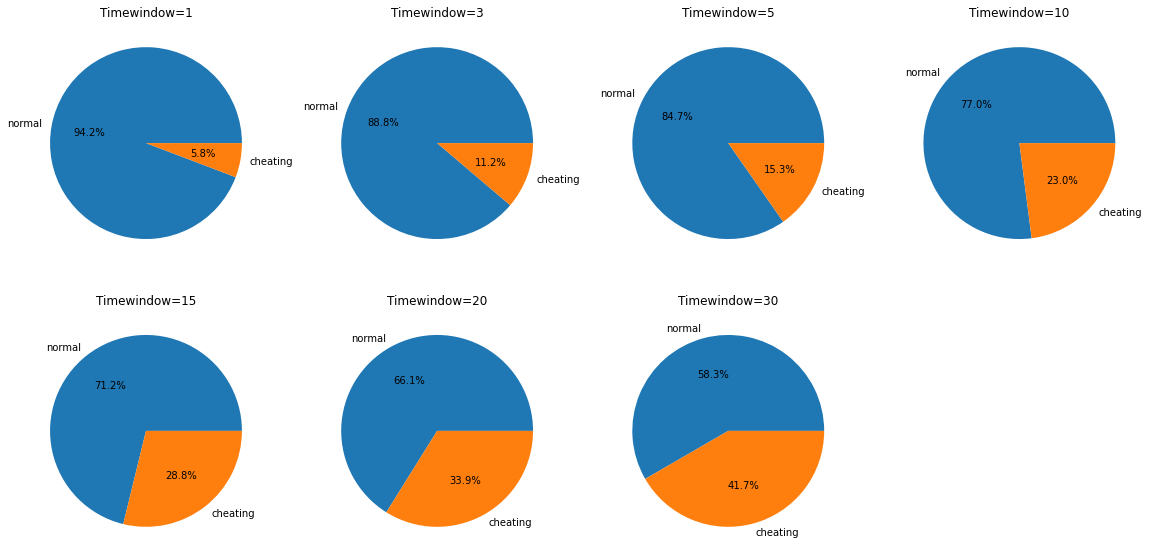

In [5]:
dfs = load_windows_data()
dfs = preprocess_pipeline(dfs)

fig = plt.figure(facecolor='white',figsize=(20, 15))

for index, df in tqdm(enumerate(dfs), "Plotting"):
    cts = df.value_counts(df['class'])
    eplodes = ['normal', 'cheat']
    plt.subplot(3, 4, index+1)
    plt.title("Timewindow="+str(timewindows[index]))
    plt.pie([cts[0], cts[2]], labels=['normal', 'cheating'], autopct='%1.1f%%')
    
plt.show()

## Supervised Learning

### 1. Decision Tree

In [6]:
def decision_tree_pipeLine():
    #data = data_preparation_pipeline()
    clfs = []
    # training
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training"):
        clf = decisionTreeTrain(X_train, y_train, 4)
        clfs.append(clf)
    # testing
    accuracy_scores, recall_scores, f1_scores, fprs = prediction_pipeline(data, clfs)
    plot_pipeline([accuracy_scores, recall_scores, f1_scores, fprs], method="Decision Tree")

Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 125.33it/s]


96.0886319845857354.4585987261146562.75229357798164625.97402597402597
95.1572448388963975.689655172413877.7679362267493320.036429872495447
94.492753623188479.62581.7190506735086616.073781291172594
93.6591041303083280.4700162074554385.862516212710797.970342910101946
93.1698774080560481.5789473684210587.033616549685996.730007917656374
92.0913884007029882.4783861671469887.603305785123966.592689295039164
91.189773844641185.1282051282051289.073170731707326.59846547314578


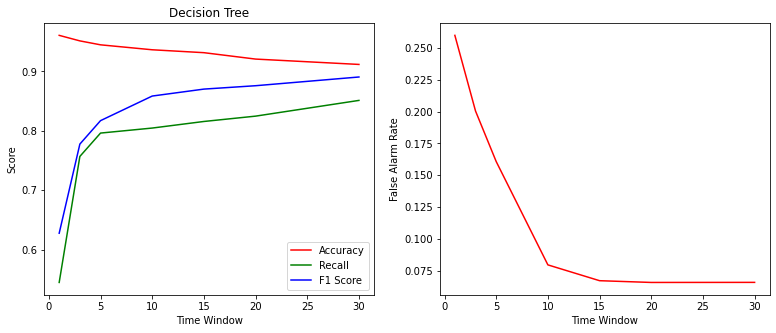

In [7]:
max_depths = [4]
decision_tree_pipeLine()

### 2. Random Forest

In [8]:
def random_forest_pipeLine():
    #data = data_preparation_pipeline()
    clfs = []
    # training
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training"):
        clf = randomForestTrain(X_train, y_train, 4)
        clfs.append(clf)
    # testing
    accuracy_scores, recall_scores, f1_scores, fprs = prediction_pipeline(data, clfs)
    plot_pipeline([accuracy_scores, recall_scores, f1_scores, fprs], method="Random Forest")

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 25.16it/s]


95.3371868978805436.9426751592356748.9451476793248927.500000000000004
94.7520740883658267.5862068965517374.2424242424242417.647058823529413
94.5314009661835875.581.0194500335345412.590448625180898
93.3682373472949478.768233387358285.039370078740167.604562737642586
92.8001556723097879.7091412742382286.152694610778446.270358306188925
91.6227299355594680.6916426512968386.714152988541346.291834002677376
90.8161258603736683.6363636363636388.48335388409376.0732984293193715


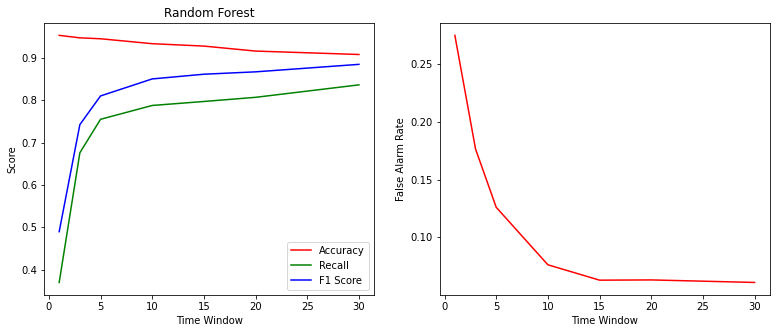

In [9]:
max_depths = [4]
random_forest_pipeLine()

### 3. Support Vector Machine(SVM)

In [10]:
def svm_pipeLine():
    #data = data_preparation_pipeline()
    clfs = []
    # training
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training"):
        clf = SVMTrain(X_train, y_train)
        clfs.append(clf)
    # testing
    accuracy_scores, recall_scores, f1_scores, fprs = prediction_pipeline(data, clfs)
    plot_pipeline([accuracy_scores, recall_scores, f1_scores, fprs], method="SVM")

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.18it/s]


96.1657032755298664.331210191082866.9983416252072930.103806228373703
95.3887709820567375.5172413793103378.5650224215246618.13084112149533
94.8792270531400880.37582.9142488716956914.380825565912117
94.0663176265270583.2252836304700287.033898305084758.792184724689166
93.7731076084841483.7257617728531988.312636961285626.568778979907264
92.7943760984182784.4380403458213488.814792361321626.32992327365729
92.4680432645034486.8531468531468590.678997322949635.142566191446028


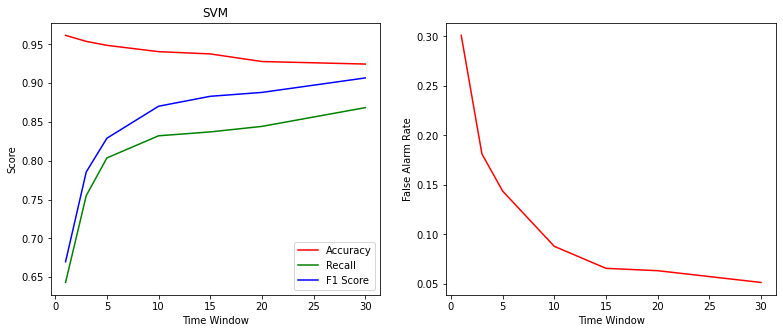

In [11]:
svm_pipeLine()

### 4. KNN

In [12]:
def KNN_pipeLine():
    #data = data_preparation_pipeline()
    clfs = []
    # training
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training"):
        clf = KNNTrain(X_train, y_train)
        clfs.append(clf)
    # testing
    accuracy_scores, recall_scores, f1_scores, fprs = prediction_pipeline(data, clfs)
    plot_pipeline([accuracy_scores, recall_scores, f1_scores, fprs], method="KNN")

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.37it/s]


93.8342967244701425.47770700636942833.33333333333333651.80722891566265
90.9897742620104148.4482758620689754.6161321671525837.41648106904232
90.125603864734359.2564.9760109664153628.072837632776938
88.3459375605972570.5024311183144274.3272105937633521.40921409214092
88.2272815722903276.6620498614958478.5384888258247719.490909090909092
90.2558094122241882.3054755043227785.1266766020864311.851851851851853
89.518190757128886.0139860139860187.3786407766990311.212704523580367


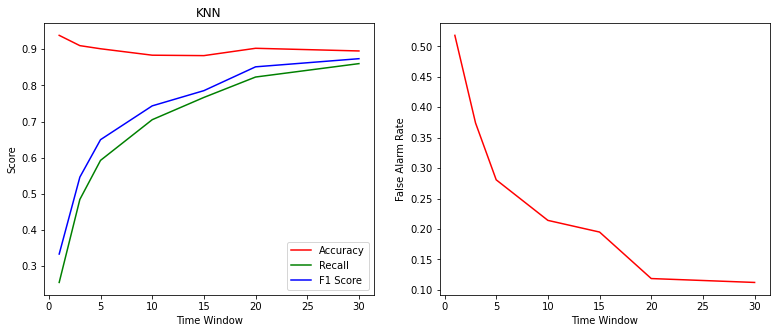

In [13]:
KNN_pipeLine()

In [74]:
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.mixture import GaussianMixture

def GMM_pipeline(n):
    #data = data_preparation_pipeline()
    #features = ['average_mouse_speed', 'useful', 'useless']
    clfs = []
    accuracy_scores = []
    recall_scores = []
    f1_scores =[]
    fprs =[]
    for [X_train, X_test, y_train, y_test] in tqdm(data, desc="Training and evaluating"):
        features = ['dist_s', 'angle_s', 'mean_dist', 'min_dist', 'view_dist','average_mouse_speed', 'useful', 'useless', 'aiming', 'shooting','moving']
        X_train['Class']= y_train
        train = X_train[X_train['Class']==0]
        X_test = X_test[features]
        X_test['Class']= y_test
        valid, test = train_test_split(X_test, test_size=0.5)
        gmm = GMMTrain(train[features], n)
        print("train set score: ", gmm.score(train[features]))
        print("valid_n score: ", gmm.score(valid[valid['Class']==0].drop('Class', axis = 1)))
        print("valid_a score: ", gmm.score(valid[valid['Class']==1].drop('Class', axis = 1)))
        tresholds = np.linspace(-100, 0, 100)
        scores = []
        for treshold in tresholds:
            y_hat = (gmm.score_samples(valid[features]) < treshold).astype(int)
            cm = confusion_matrix(y_pred=y_hat, y_true=valid['Class'].values)
            tn, fp, fn, tp = cm.ravel()
            fpr = fp/(fp+tn)
            scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
            precision_score(y_pred=y_hat, y_true=valid['Class'].values),
            f1_score(y_pred=y_hat, y_true=valid['Class'].values), fpr])  
        scores = np.array(scores)
        plt.plot(tresholds, scores[:, 0], label='$Recall$')
        plt.plot(tresholds, scores[:, 1], label='$Precision$')
        plt.plot(tresholds, scores[:, 2], label='$F_1$')
        plt.plot(tresholds, scores[:, 3], label='$False Alarm$')
        plt.ylabel('Score')
        # plt.xticks(np.logspace(-10, -200, 3))
        plt.xlabel('Threshold')
        plt.legend(loc='best')
        plt.show()
        print('The final threshold selected is: ', scores[:, 2].max(), tresholds[scores[:, 2].argmax()])
        best_threshold = tresholds[scores[:, 2].argmax()]
        y_hat = (gmm.score_samples(test[features]) < best_threshold).astype(int)
        accuracy_scores.append(accuracy_score(y_pred=y_hat, y_true=test['Class'].values))
        recall_scores.append(recall_score(y_pred=y_hat, y_true=test['Class'].values))
        f1_scores.append(f1_score(y_pred=y_hat, y_true=test['Class'].values))
        tn, fp, fn, tp = confusion_matrix(y_pred=y_hat, y_true=test['Class'].values).ravel()
        fprs.append(fp/(fp+tn))
    plot_pipeline([accuracy_scores, recall_scores, f1_scores, fprs], method="GMM")

Training and evaluating:   0%|                                                                   | 0/7 [00:00<?, ?it/s]

train set score:  -7.977042931664016
valid_n score:  -7.481630964049249
valid_a score:  -49.4468075408846


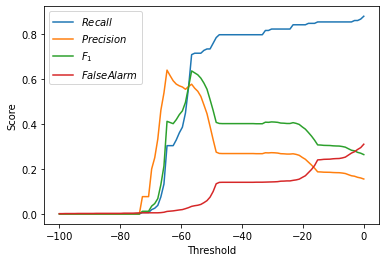

Training and evaluating:  14%|████████▍                                                  | 1/7 [00:01<00:07,  1.26s/it]

The final threshold selected is:  0.6363636363636364 -56.56565656565656
train set score:  -17.521738244741787
valid_n score:  -17.96380924747838
valid_a score:  -64.24134790800551


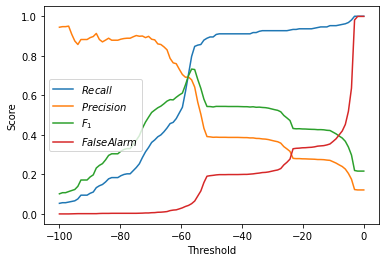

Training and evaluating:  29%|████████████████▊                                          | 2/7 [00:02<00:06,  1.26s/it]

The final threshold selected is:  0.7328467153284672 -56.56565656565656
train set score:  -14.316030899183295
valid_n score:  -15.231379137391512
valid_a score:  -58.55873731929476


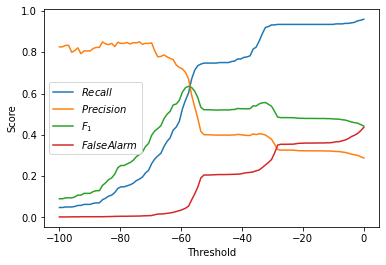

Training and evaluating:  43%|█████████████████████████▎                                 | 3/7 [00:03<00:05,  1.28s/it]

The final threshold selected is:  0.6350461133069829 -57.57575757575757
train set score:  -35.66495395866341
valid_n score:  -35.49098589967278
valid_a score:  -60.24143141899505


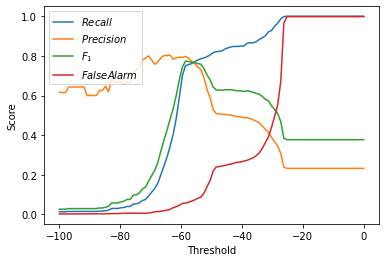

Training and evaluating:  57%|█████████████████████████████████▋                         | 4/7 [00:05<00:03,  1.32s/it]

The final threshold selected is:  0.7734711455641688 -58.58585858585858
train set score:  -37.43710115784266
valid_n score:  -37.58736236409906
valid_a score:  -61.67137525922261


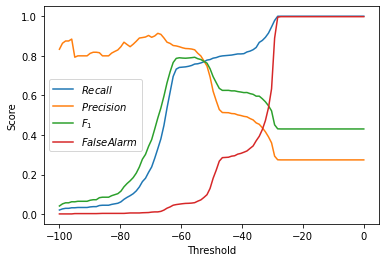

Training and evaluating:  71%|██████████████████████████████████████████▏                | 5/7 [00:06<00:02,  1.29s/it]

The final threshold selected is:  0.7928730512249444 -55.55555555555555
train set score:  -39.11111555105073
valid_n score:  -38.94528855196189
valid_a score:  -63.25687848957512


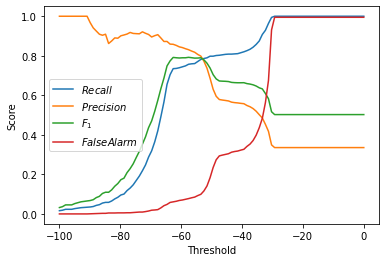

Training and evaluating:  86%|██████████████████████████████████████████████████▌        | 6/7 [00:07<00:01,  1.31s/it]

The final threshold selected is:  0.7921760391198044 -57.57575757575757
train set score:  -41.10794689163037
valid_n score:  -40.962207748040235
valid_a score:  -66.68054454940844


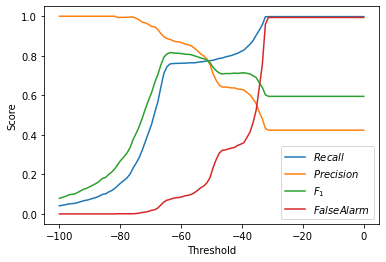

Training and evaluating: 100%|███████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]

The final threshold selected is:  0.8162243365047571 -63.63636363636363
94.1425818882466267.9487179487179658.2417582417582344.182041820418204
92.8240740740740873.962264150943467.820069204152255.027932960893855
88.446676970633755.0000000000000159.539918809201635.4387568555758685
88.5614579294371.6981132075471775.559237779618885.918682449819866
87.6653696498054474.3243243243243277.628793225123496.939890710382514
86.9191721983600275.6541524459613279.879879879879887.193816884661118
86.5119937082186478.9915966386554783.144963144963148.016304347826086


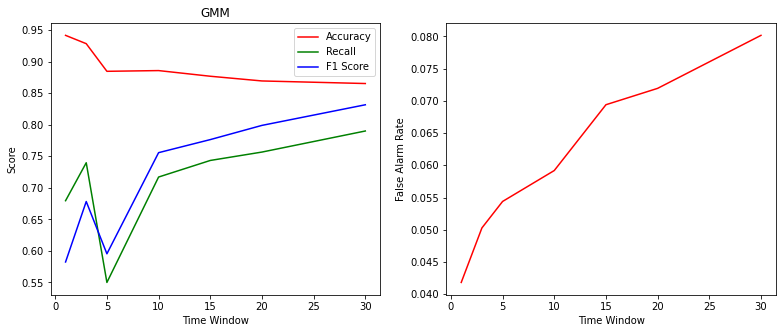

In [75]:
GMM_pipeline(5)


In [76]:
from sklearn.metrics import ConfusionMatrixDisplay
def Dual_pipeline(diraction):
    # gmm part 
    #data = data_preparation_pipeline()
    #features = ['average_mouse_speed', 'useful', 'useless']
    X_train, X_test, y_train, y_test = data[6]
    features = ['dist_s', 'angle_s', 'mean_dist', 'min_dist', 'view_dist','average_mouse_speed', 'useful', 'useless', 'aiming', 'shooting','moving']
    clf = SVMTrain(X_train[features], y_train)
    X_train['Class']= y_train
    train = X_train[X_train['Class']==0]
    X_test = X_test[features]
    X_test['Class']= y_test
    valid, test = train_test_split(X_test, test_size=0.5)
    gmm = GMMTrain(train[features], 5)
    tresholds = np.linspace(-100, 1, 100)
    scores = []
    for treshold in tqdm(tresholds):
        y_hat = (gmm.score_samples(valid[features]) < treshold).astype(int)
        for index, y in enumerate(y_hat):
            if y == diraction:
                continue
            tmp = clf.predict(np.array(valid[features].iloc[index]).reshape(1, -1))
            y_hat[index] = tmp
        cm = confusion_matrix(y_pred=y_hat, y_true=valid['Class'].values)
        tn, fp, fn, tp = cm.ravel()
        fpr = fp/(fp+tn)
        scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
        precision_score(y_pred=y_hat, y_true=valid['Class'].values),
        f1_score(y_pred=y_hat, y_true=valid['Class'].values), fpr])  
    scores = np.array(scores)
    plt.plot(tresholds, scores[:, 0], label='$Recall$')
    plt.plot(tresholds, scores[:, 1], label='$Precision$')
    plt.plot(tresholds, scores[:, 2], label='$F_1$')
    plt.plot(tresholds, scores[:, 3], label='$False Alarm$')
    plt.ylabel('Score')
    # plt.xticks(np.logspace(-10, -200, 3))
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.show()
    print('The final threshold selected is: ', scores[:, 2].max(), tresholds[scores[:, 2].argmax()])
    best_threshold = tresholds[scores[:, 2].argmax()]
    y_hat = (gmm.score_samples(test[features]) < best_threshold).astype(int)
    i = 0
    for index, y in tqdm(enumerate(y_hat), desc="Testing"):
        if y == diraction:
            continue
        tmp = clf.predict(np.array(test[features].iloc[index]).reshape(1, -1))
        y_hat[index] = tmp
        i+=1
    print(i)
    accuracy, recall, f1_s = predict_scores(test['Class'].values, y_hat)
    cm = confusion_matrix(y_pred=y_hat, y_true=test['Class'].values)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp/(fp+tn)
    print("DUAL:")
    print(accuracy, recall, f1_s, fpr)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    svm_y_hat= clf.predict(test[features]) 
    # calculate svm
    svm_cm = confusion_matrix(y_pred=svm_y_hat, y_true=test['Class'].values)
    accuracy, recall, f1_s = predict_scores(test['Class'].values, svm_y_hat)
    tn, fp, fn, tp = svm_cm.ravel()
    fpr = fp/(fp+tn)
    print("svm:")
    print(accuracy, recall, f1_s, fpr)
    disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm)
    disp.plot()
    plt.show()
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


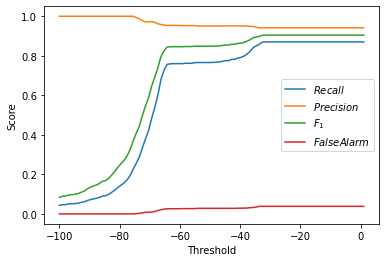

The final threshold selected is:  0.9044334975369459 -31.64646464646465


Testing: 2543it [00:02, 966.74it/s] 


2533
DUAL:
0.9256783326779394 0.8669724770642202 0.9090909090909092 0.030282174810736407


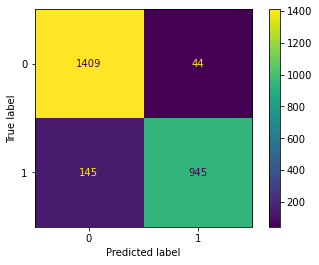

svm:
0.9256783326779394 0.8669724770642202 0.9090909090909092 0.030282174810736407


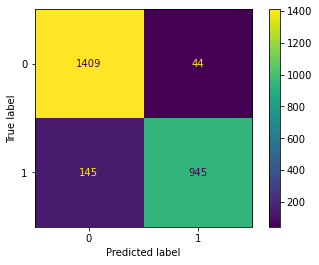

In [77]:
Dual_pipeline(0)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential

In [4]:
df = load_data("../csv_data/user_1_timewindow1.csv")
df = df.fillna(-10000)
# df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
df = df.replace((np.inf, -np.inf), 0).reset_index(drop=True)
df.count()

NameError: name 'load_data' is not defined